### Hyper-parameter Tunning with Genetic Algorithm
#### Created: Dec. 29 2018

In [1]:
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os

In [2]:
import sys
sys.path.append("../")
# If this notebook file is not placed under in /notebook/ directory,
# adding directory "../" might not correly add the project directory.
# If adding "../" does not solve the importing problem, we need to setup 
# the directory mannually.
try:
    import constants
except ModuleNotFoundError:
    core_dir = input("Directory of core files >>> ")
    if not core_dir.endswith("/"):
        core_dir += "/"
    sys.path.append(core_dir)
    import constants

In [3]:
import core.genetic.control as control
import core.genetic.tuner as tuner
import core.models.stacked_lstm as stacked_lstm

In [4]:
# Load dataset.
print("Dataset paths saved:")
pprint(constants.DATA_DIR)
choice = None
while choice is None or choice not in constants.DATA_DIR.keys():
    if choice is not None:
        print("Invalid data location received, try again...")
    choice = input("Select Dataset >>> ")
FILE_DIR = constants.DATA_DIR[choice]
print(f"Dataset chosen: {FILE_DIR}")

Dataset paths saved:
{'a': '/Users/tianyudu/Documents/Academics/EconForecasting/AnnEconForecast/data/UNRATE.csv',
 'b': '/home/ec2-user/AnnEconForecast/data/UNRATE.csv',
 'c': '/home/ec2-user/AnnEconForecast/data/DEXCAUS.csv'}
Select Dataset >>> b
Dataset chosen: /home/ec2-user/AnnEconForecast/data/UNRATE.csv


In [5]:
# Load configuration.
print("Avaiable configuration files found: ")
for cf in os.listdir("../hps_configs"):
    print("\t" + cf)

config_name = input("Select config file >>> ")
if config_name.endswith(".py"):
    config_name = config_name[:-3]
# config_name = "mac_config"

exec(f"import hps_configs.{config_name} as config")

Avaiable configuration files found: 
	__pycache__
	ec2_config.py
	mac_config.py
	.ipynb_checkpoints
	ec2_lite_config.py
	template.py
Select config file >>> ec2_config


In [6]:
# Training Spec.
GENE_POOL = config.main
TOTAL_GEN = 20
POP_SIZE = 30
IGNORE_SET = (
    "PERIODS", "ORDER", "TRAIN_RATIO", "VAL_RATIO", "num_outputs", "num_inputs", "report_periods",
    "tensorboard_path", "model_path", "fig_path"
)

In [7]:
def eval_net_wrapper(param):
    return control.eval_net(
        model=stacked_lstm.StackedLSTM,
        param=param,
        file_dir=FILE_DIR,
        metric="mse_val",
        smooth_metric=0.05
    )

In [8]:
# Create the Optimizer.
optimizer = tuner.GeneticTuner(
    gene_pool=config.main,
    pop_size=POP_SIZE,
    eval_func=eval_net_wrapper,
    mode="min",
    retain=0.3,
    shot_prob=0.05,
    mutate_prob=0.15,
    verbose=False,
    ignore=IGNORE_SET
)

In [9]:
start_time = datetime.datetime.now()

In [10]:
elite = control.train_op(
    optimizer=optimizer,
    total_gen=TOTAL_GEN,
    elite=0.5
)

Generation: [0/20]
Evaluating the initial population.
 ############################## Evaluating... [30/30, 100.00%] Current Net: size=(64, 64, 128, 128), ep=300, lr= 0.0100000
Best fitted entity validatiton MSE:  0.0229891        
Worst fitted entity validation MSE:  290.7239075
Generation: [1/20]
 ############################## Evaluating... [30/30, 100.00%] Current Net: size=(118, 213), ep=300, lr= 1.0520 lr= 1.0095
Best fitted entity validatiton MSE:  0.0236641        
Worst fitted entity validation MSE:  6893.8906250
Generation: [2/20]
 ############################## Evaluating... [30/30, 100.00%] Current Net: size=(64, 64), ep=300, lr= 0.028077lr= 0.0171
Best fitted entity validatiton MSE:  0.0239720        
Worst fitted entity validation MSE:  23628.9316406
Generation: [3/20]
 ############################### Evaluating... [31/31, 100.00%] Current Net: size=(83, 152), ep=364, lr= 0.02281 1.0189215
Best fitted entity validatiton MSE:  0.0245002        
Worst fitted entity validati

In [11]:
end_time = datetime.datetime.now()
print(f"Time taken: {end_time - start_time}")

Time taken: 1:10:53.201275


In [12]:
# Report
print("Best found:")
print(list(elite.values())[-1][0])

Best found:
({'PERIODS': 1, 'ORDER': 1, 'LAGS': 6, 'TRAIN_RATIO': 0.8, 'VAL_RATIO': 0.1, 'epochs': 735, 'num_inputs': 1, 'num_outputs': 1, 'num_time_steps': 6, 'num_neurons': (118, 136), 'learning_rate': 0.01387512538671118, 'clip_grad': None, 'report_periods': 10, 'tensorboard_path': '/home/ec2-user/ec2_hps/2018DEC21_01/tensorboard/', 'model_path': '/home/ec2-user/ec2_hps/2018DEC21_01/saved_models/', 'fig_path': '/home/ec2-user/ec2_hps/2018DEC21_01/model_figs/'}, 0.023522917181253433)


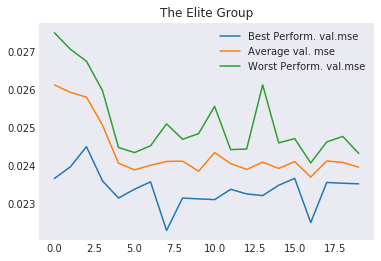

In [13]:
plt.close()
plt.style.use('seaborn-dark')
plt.title("The Elite Group")
plt.plot([
    elite_gp[0][1] 
    for elite_gp in list(elite.values())
    ]
)
plt.plot([
    np.mean([x[1] for x in elite_gp])
    for elite_gp in list(elite.values())
    ]
)
plt.plot([
    elite_gp[-1][1] 
    for elite_gp in list(elite.values())]
)
plt.legend(
    ["Best Perform. val.mse", "Average val. mse", "Worst Perform. val.mse"],
    loc="best"
)
plt.show()